In [1]:
import tensorflow as tf
import numpy as np
import tensorflow.contrib.layers as layers

In [2]:
from sklearn.datasets import make_moons
from matplotlib import pyplot as plt
from flows import NVPFlow, FlowSequence, ResFlow, BNFlow, phase, floatX

In [3]:
inp = tf.placeholder(floatX, [None, 2])

In [4]:
flow = NVPFlow(2, 'init_flow')(inp)

for i in range(0, 16):
    if i != 0:
        flow = NVPFlow(name='dense_' + str(i))(flow)
    flow = ResFlow(name='res_' + str(i))(flow)
    flow = BNFlow(name='bn_' + str(i))(flow)

In [5]:
flow[-1].output /= 4

In [6]:
flow[-1].logj.shape

TensorShape([])

In [7]:
flows = FlowSequence(flow[1:])

In [8]:
logj = flows.calc_logj()

In [9]:
logj

<tf.Tensor 'add_47:0' shape=(?,) dtype=float64>

In [10]:
mm = np.zeros(2, np.int)
for fl in flows:
    if hasattr(fl, 'mask'):
        mm += fl.mask

In [11]:
mm

array([16, 16])

In [12]:
with tf.name_scope('gain_scope'):
    z = flows[-1].output
    gain = tf.reduce_sum(-(z*z)/2, axis=-1) + logj
    gain = tf.reduce_mean(gain)

In [13]:
z

<tf.Tensor 'truediv:0' shape=(?, 2) dtype=float64>

In [14]:
train_op = tf.train.AdamOptimizer(0.0001).minimize(-gain)
train_op = [train_op] + flows.ops

In [15]:
X, _ = make_moons(n_samples=1024, noise=0.13)

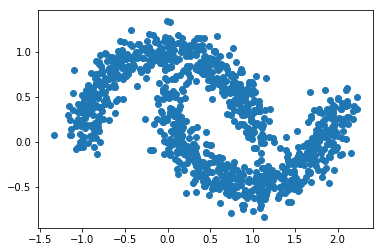

In [16]:
plt.scatter(X[:,0], X[:,1])
plt.show()

In [17]:
sess = tf.InteractiveSession()

In [18]:
tf.global_variables_initializer().run()

In [19]:
logj.eval({inp:X, phase: False}).mean()

-22.787327401793064

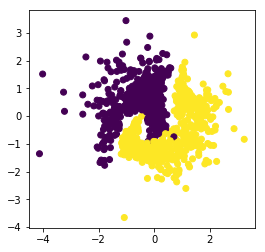

In [26]:
X, y = make_moons(n_samples=1024, noise=0.13)
ver = z.eval({inp:X})

ax = plt.gca()
ax.set_aspect('equal')
plt.scatter(ver[:,0], ver[:,1], c=y)
plt.show()

In [21]:
writer = tf.summary.FileWriter('/tmp/tfdbg')

In [22]:
writer.add_graph(tf.get_default_graph())

In [25]:
for _ in range(400):
    for _ in range(1000):
        X, _ = make_moons(n_samples=256, noise=0.13)
        sess.run(train_op, {inp:X})
    print(gain.eval({inp:X}).mean())

-8.172408649400428
-8.126294392289164
-8.095451583993476
-8.161558102936853
-8.07747776528887
-8.099947223778045
-8.178321693215668
-8.15657154580045
-8.192722019636207
-8.107750423684466
-8.13071621871426
-8.168057450996415
-8.10963319478254
-8.134763957361596
-8.138778236851032
-8.174936291708182
-8.084047773830157
-8.166103811676924
-8.124570351086682


KeyboardInterrupt: 

In [27]:
inverse = flows.apply(inp*4, inverse=True)

In [28]:
restored = inverse.eval({inp:np.random.normal(size=[400,2]), phase: False})
#restored = inverse.eval({inp:ver})

In [29]:
restored = restored[np.logical_not(np.any(restored**2 > 10, axis=-1))]

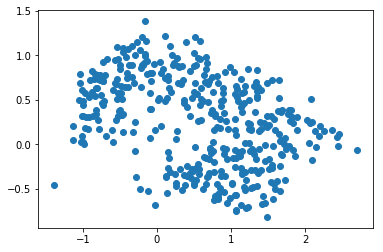

In [30]:
plt.scatter(restored[:,0], restored[:,1])
plt.show()

In [32]:
flows.ops

[]